# Prophet

## imports and setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
# Add the project root to the Python path
sys.path.append(os.path.abspath(".."))
from src.models.prophet_model import (
    prepare_prophet_input,
    train_prophet,
    make_future_forecast
)
from src.utils.preprocess import (
    load_series_from_csv,
    preprocess_series,
    merge_series_dict,
    add_derived_features,
    train_test_split_time_series
)

# Plot
def plot_forecast_with_legend(forecast_df: pd.DataFrame, original_df: pd.DataFrame, title: str = "Forecast"):
    """
    Plot Prophet forecast alongside the original data with a proper legend.
    """
    plt.figure(figsize=(12, 5))

    # Plot historical data
    plt.plot(original_df["ds"], original_df["y"], label="Actual", color="black", alpha=0.6)

    # Forecast and confidence intervals
    plt.plot(forecast_df["ds"], forecast_df["yhat"], label="Forecast", color="blue")
    plt.fill_between(
        forecast_df["ds"],
        forecast_df["yhat_lower"],
        forecast_df["yhat_upper"],
        color="blue",
        alpha=0.2,
        label="Confidence Interval"
    )

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_forecast_with_forecast_window(forecast_df, original_df, cutoff_date, title="Forecast"):
    """
    Plot Prophet forecast with shaded forecast region starting at cutoff_date.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    # Actual values
    plt.plot(original_df["ds"], original_df["y"], label="Actual", color="black", alpha=0.6)

    # Full forecast line
    plt.plot(forecast_df["ds"], forecast_df["yhat"], label="Forecast (yhat)", color="blue")

    # Confidence interval
    plt.fill_between(
        forecast_df["ds"],
        forecast_df["yhat_lower"],
        forecast_df["yhat_upper"],
        color="blue",
        alpha=0.2,
        label="Confidence Interval"
    )

    # Shade forecast range
    forecast_start = pd.to_datetime(cutoff_date)
    forecast_end = forecast_df["ds"].max()
    plt.axvspan(forecast_start, forecast_end, color='orange', alpha=0.1, label="Forecast Horizon")

    plt.axvline(forecast_start, color='orange', linestyle='--', alpha=0.6)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()



/Users/jjgutzmann/coding/projects/economic_data_analysis_with_pandas/.econenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Forecast and plot S&P500 data

16:30:50 - cmdstanpy - INFO - Chain [1] start processing
16:30:51 - cmdstanpy - INFO - Chain [1] done processing


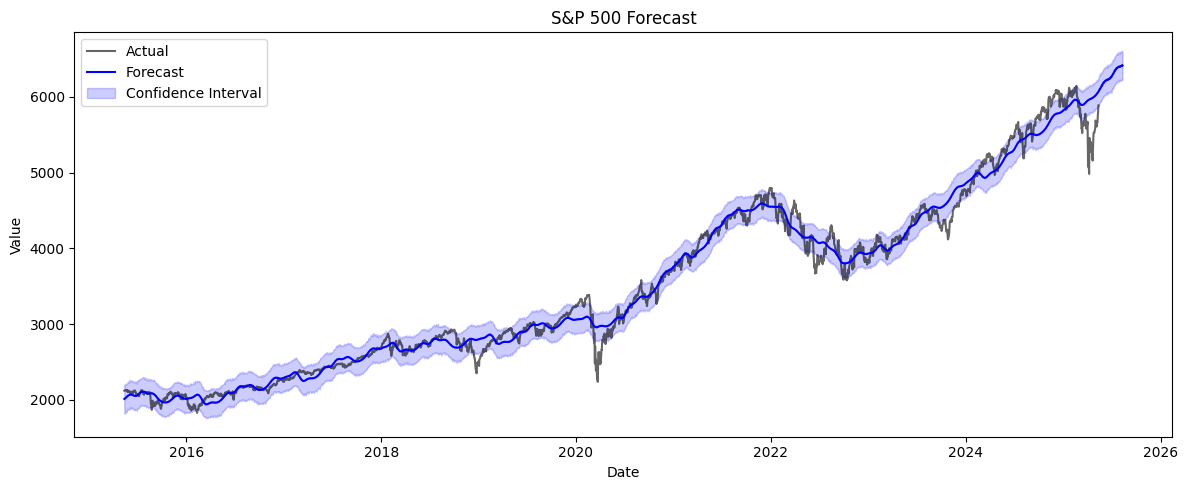

In [2]:
# Forecast actual S&P 500 values (not % change)
df = load_series_from_csv("sp500.csv")
df_clean = preprocess_series(df, freq="B")
df_clean = df_clean.dropna()

# Prophet expects raw levels, not returns
df_prophet = prepare_prophet_input(df_clean)

# Train & forecast
model = train_prophet(df_prophet)
forecast = make_future_forecast(model, periods=90)

plot_forecast_with_legend(forecast, df_prophet, title="S&P 500 Forecast")

## Forecast and plot USD/EUR exchange rates

16:30:55 - cmdstanpy - INFO - Chain [1] start processing
16:31:01 - cmdstanpy - INFO - Chain [1] done processing


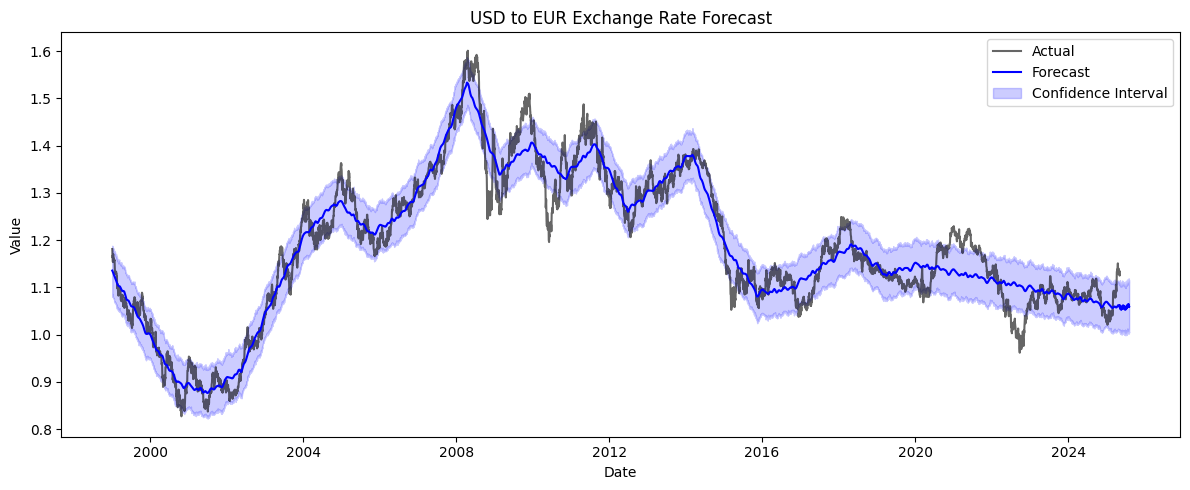

In [3]:
# Load and prepare exchange rate series
usd_eur = load_series_from_csv("usd_eur.csv")
usd_eur_clean = preprocess_series(usd_eur, freq="B").dropna()
usd_eur_prophet = prepare_prophet_input(usd_eur_clean)

# Train and forecast
model_usd_eur = train_prophet(usd_eur_prophet)
forecast_usd_eur = make_future_forecast(model_usd_eur, periods=90)

# Plot
plot_forecast_with_legend(forecast_usd_eur, usd_eur_prophet, title="USD to EUR Exchange Rate Forecast")


## Forecast and plot CPI

16:54:59 - cmdstanpy - INFO - Chain [1] start processing
16:55:00 - cmdstanpy - INFO - Chain [1] done processing
/Users/jjgutzmann/coding/projects/economic_data_analysis_with_pandas/.econenv/lib/python3.13/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


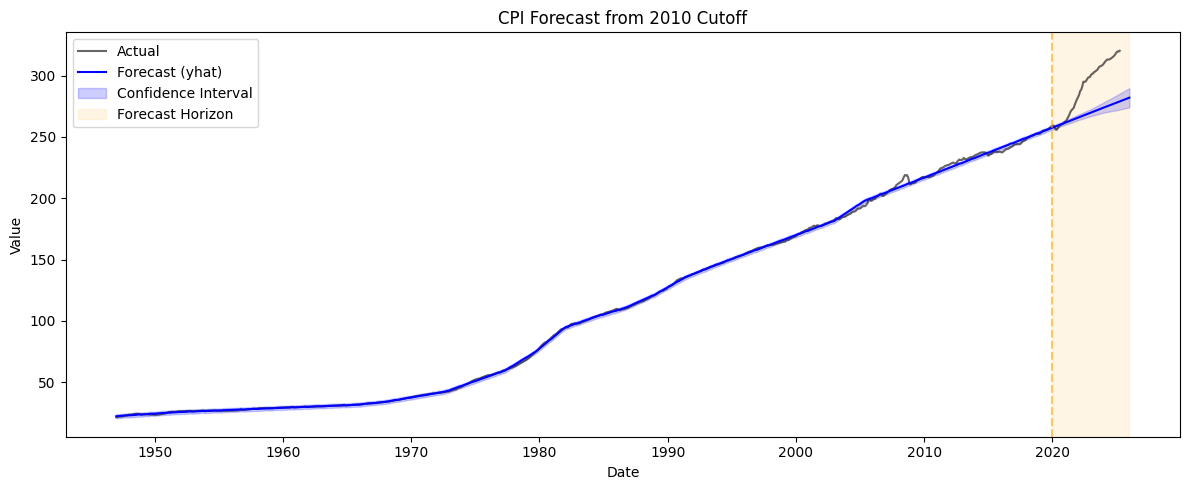

In [6]:
# define cutoff date
train_cutoff = pd.to_datetime("2020-01-01")

# Load and prepare CPI series
cpi = load_series_from_csv("cpi.csv")
cpi_clean = preprocess_series(cpi, freq="MS").dropna()
cpi_prophet = prepare_prophet_input(cpi_clean)

# Use only data up to the cutoff for training
train_df = cpi_prophet[cpi_prophet["ds"] <= train_cutoff]

# Train and forecast
model = train_prophet(train_df)
forecast = make_future_forecast(model, periods=6, freq='Y')  # 4 years

# Plot
# plot_forecast_with_legend(forecast, cpi_prophet, title=f"Prophet Forecast with {str(train_cutoff)[0:4]} Cutoff")
plot_forecast_with_forecast_window(
    forecast_df=forecast,
    original_df=cpi_prophet,
    cutoff_date=train_cutoff,
    title="CPI Forecast from 2010 Cutoff"
)



In [2]:
from src.models.prophet_backtest import prophet_backtest

# Load CPI series
cpi = load_series_from_csv("cpi.csv")
cpi_clean = preprocess_series(cpi, freq="MS")

cutoffs = ["2000-01-01", "2010-01-01", "2018-01-01"]

bt_results = prophet_backtest(cpi_clean, cutoff_dates=cutoffs, forecast_horizon=24, freq="MS")

print(bt_results)


16:40:02 - cmdstanpy - INFO - Chain [1] start processing
16:40:03 - cmdstanpy - INFO - Chain [1] done processing
16:40:03 - cmdstanpy - INFO - Chain [1] start processing
16:40:03 - cmdstanpy - INFO - Chain [1] done processing
16:40:04 - cmdstanpy - INFO - Chain [1] start processing
16:40:04 - cmdstanpy - INFO - Chain [1] done processing


       cutoff  horizon       MAE      RMSE
0  2000-01-01       24  0.580646  0.711616
1  2010-01-01       24  1.313996  1.713982
2  2018-01-01       24  1.191676  1.286783
